# Web Map Services (WMS) and Web Coverage Services (WCS) for GemGIS

This Notebook is demonstrating how Web Map Services can be used with GemGIS. 

**Content:**
- What is a WebMapService?
- What is a WebCoverage Service?
- Installing owslib
- Importing Libraries
- Definition of Functions
- Loading WebMapService
- Loading WebMapService - NRW
- Loading WebCoverage Service 


**What is a Web Map Service?** <br>
A Web Map Service (WMS) is a standard protocol developed by the Open Geospatial Consortium in 1999 for serving georeferenced map images over the Internet. These images are typically produced by a map server from data provided by a GIS database. (https://en.wikipedia.org/wiki/Web_Map_Service)

**What is a Web Coverage Service?**<br>
The Open Geospatial Consortium Web Coverage Service Interface Standard (WCS) defines Web-based retrieval of coverages – that is, digital geospatial information representing space/time-varying phenomena. (https://en.wikipedia.org/wiki/Web_Coverage_Service)

This means that map data is stored on a server but we can still access and utilize it. 

The library ```OWSLib``` will be used to retrieve the data from the serves. A link to the GeoPython Webpage is provided here: https://geopython.github.io/OWSLib/.
The library can easily be installed via Anaconda prompt executing ```conda install -c conda-forge owslib``` or using ```pip```. It is not dependent on GDAL.


# Installing OWSLib


In [1]:
%pip install owslib

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: certifi>=2017.4.17 in c:\users\user_abuser\anaconda3\lib\site-packages (from requests>=1.0->owslib) (2020.4.5.1)



# Import Libraries

In [2]:
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
import io
import matplotlib.pyplot as plt
import numpy as np

# Definition of Functions

## Loading of WMS Service
The WebMapServices can be loaded with ```load_wms```. By default, the service of Terrestris is selected. A custom link can be provided as kwarg. A ```owslib.map.wms111.WebMapService_1_1_1``` object will be returned.

In [3]:
def load_wms(**kwargs):
    """
    Loading the Web Map Service
    Args:
        
    Kwargs: 
        path: alternative file path for Web Map Service
    Returns:
        wms: owslib.map.wms111.WebMapService_1_1_1
     """
    
    path = kwargs.get('path','https://ows.terrestris.de/osm/service?')
    
    wms = WebMapService(path)
    
    return wms

## Imagery Request

Request an Image from the WebMapService and save it as Numpy Array. The default image loaded is located over North Rhine Westfalia, Germany in WGS84. Extent, size and more properties can be changed by providing kwargs to the function ```request_image_as_array```. The array will be flipped in a way that (0,0) is located in the lower left corner of the plot, similar when plotting spatial data. 

In case the model area is smaller than the working area, please create a second array with an adapted extent and resolution to fit your purposes. 

In [4]:
def request_image_as_array(wms, **kwargs):
    """
    Request imagery and convert into numpy array 
    Args:
        wms: owslib.map.wms111.WebMapService_1_1_1
    Kwargs: 
        layers list - List of content layer names 
        styles: list - Optional list of named styles, must be the same length as the layers list
        srs: string - A spatial reference system identifier.
        extent: tuple - (left, bottom, right, top) in srs units, can be the same as for GemPy
        size: tuple - (width, height) in pixels.
        format: string - Output image format such as 'image/jpeg'.
        transparent: bool - Optional. Transparent background if True.
        
    Returns:
        image: numpy.ndarray
    """
        
    layers = kwargs.get('layers', [list(wms.contents)[0]])
    

    #If WMS contains no style, styles is set to None
    if not 'styles' in kwargs:
        if not wms[list(wms.contents)[0]].styles:
            styles = kwargs.get('styles', None)
        else:
            style = [(key, wms[list(wms.contents)[0]].styles[key]) for key in wms[list(wms.contents)[0]].styles][0][0]
            styles = kwargs.get('styles', [style])
    else:
        styles = kwargs.get('styles', [style])
    
    
    srs = kwargs.get('srs', 'EPSG:4326')
    extent = kwargs.get('extent', (5, 48, 10, 53))
    size = kwargs.get('size', (2000,2000))
    form = kwargs.get('form', wms.getOperationByName('GetMap').formatOptions[1])
    transparent = kwargs.get('transparent', True)
    
    img = wms.getmap(layers=layers,
                    styles=styles,
                    srs=srs,
                    bbox=extent,
                    size=size,
                    format=form,
                    transparent=True)
    
    img = io.BytesIO(img.read())
    if form == 'image/png':
        image = plt.imread(img)
    elif form == 'image/tiff':
        image = plt.imread(img, format = 'tiff')
    image = np.flipud(image)
    return image

## Plotting

The array returned from ```request_image_as_array``` can now be plotted. If no extent is provided, the array will be plotted according to its cell numbers. If an extent is provided, the array will be projected to the provided extent (see "Plotting the Aachen Area") and additional data can be plotted as well.

In [5]:
def plot_wms(img: np.ndarray, **kwargs):
    """
    Plotting a WMS Layer as Numpy Array 
    Args:
        img: np.array - containing the WMS Layer information
    Kwargs: 
        extent: tuple - extent of the plot area in real coordinates, default will plot index number
        show_grid: bool - show or hide grid, default False
    Returns:
        
    """
    extent = kwargs.get('extent', None)
    
    if extent is not None:
        extent = (extent[0],extent[2],extent[1],extent[3])
        
    show_grid = kwargs.get('show_grid', False)
    
    fig = plt.figure(figsize=(8,8))
    plt.imshow(img, origin="lower", extent = extent)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(show_grid)
    plt.show()

## Coordinates Transformation

## Save Array as Tif

# Loading WebMapService

In [6]:
wms = load_wms()

## Get WebMapService Properties

Properties of the ```owslib.map.wms111.WebMapService_1_1_1``` object can easily be retrieved in the following way.

## Service Metadata

In [7]:
wms.identification.type

'OGC:WMS'

In [8]:
wms.identification.version

'1.1.1'

In [9]:
wms.identification.title

'OpenStreetMap WMS'

In [10]:
wms.identification.abstract

'OpenStreetMap WMS, bereitgestellt durch terrestris GmbH und Co. KG. Beschleunigt mit MapProxy (http://mapproxy.org/)'

## Available Layers

In [11]:
list(wms.contents)

['OSM-WMS',
 'OSM-Overlay-WMS',
 'TOPO-WMS',
 'TOPO-OSM-WMS',
 'SRTM30-Hillshade',
 'SRTM30-Colored',
 'SRTM30-Colored-Hillshade',
 'SRTM30-Contour']

## Details of a Layer

In [12]:
wms['OSM-WMS'].title

'OpenStreetMap WMS - by terrestris'

In [13]:
wms['OSM-WMS'].queryable

1

In [14]:
wms['OSM-WMS'].opaque

0

In [15]:
 wms['OSM-WMS'].boundingBox

(-20037508.3428, -25819498.5135, 20037508.3428, 25819498.5135, 'EPSG:900913')

In [16]:
wms['OSM-WMS'].boundingBox

(-20037508.3428, -25819498.5135, 20037508.3428, 25819498.5135, 'EPSG:900913')

In [17]:
wms['OSM-WMS'].boundingBoxWGS84

(-180.0, -88.0, 180.0, 88.0)

In [18]:
wms['OSM-WMS'].crsOptions

['EPSG:3034',
 'EPSG:31467',
 'EPSG:900913',
 'EPSG:2180',
 'EPSG:25833',
 'EPSG:29193',
 'EPSG:3857',
 'EPSG:4647',
 'EPSG:2056',
 'EPSG:2100',
 'EPSG:4258',
 'EPSG:31463',
 'EPSG:3035',
 'EPSG:4686',
 'EPSG:31468',
 'EPSG:29192',
 'EPSG:4839',
 'EPSG:32648',
 'EPSG:25832',
 'EPSG:21781',
 'EPSG:31466',
 'EPSG:3068',
 'EPSG:4674',
 'EPSG:5243',
 'EPSG:4326']

In [19]:
wms['OSM-WMS'].styles

{'default': {'title': 'default',
  'legend': 'http://ows.terrestris.de/osm/service?styles=&layer=OSM-WMS&service=WMS&format=image%2Fpng&sld_version=1.1.0&request=GetLegendGraphic&version=1.1.1'}}

## Available Methods, their URLs and available formats

In [20]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'GetLegendGraphic']

In [21]:
wms.getOperationByName('GetMap').methods

[{'type': 'Get', 'url': 'http://ows.terrestris.de/osm/service?'}]

In [22]:
wms.getOperationByName('GetMap').formatOptions

['image/jpeg', 'image/png']

## Requesting Data and Plot

In [23]:
img = request_image_as_array(wms)

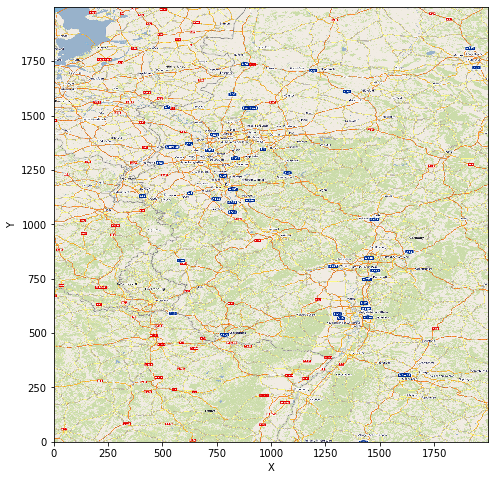

In [24]:
plot_wms(img)

## Plotting the "Aachen Area"

The "Aachen Area" was requested and plotted below. The resolution of each cell is 100 m. 

In [25]:
minx = 32286000
maxx = 32328000
miny = 5620000
maxy = 5648000

extent = (minx,miny,maxx,maxy)

img2 = request_image_as_array(wms, srs = 'EPSG:4647', extent = extent, size = (int((maxx-minx)/10),int((maxy-miny)/10)))

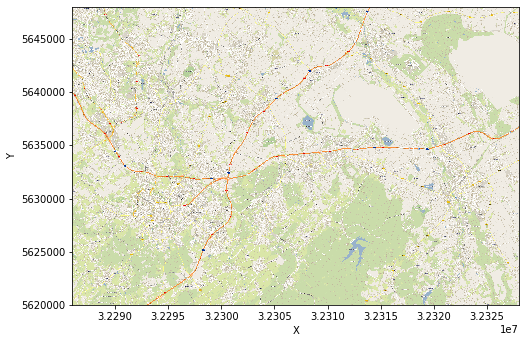

In [26]:
plot_wms(img2, extent = extent)

## Plotting a subset of the array including random points (e.g. wells)

(2000, 2000, 3)


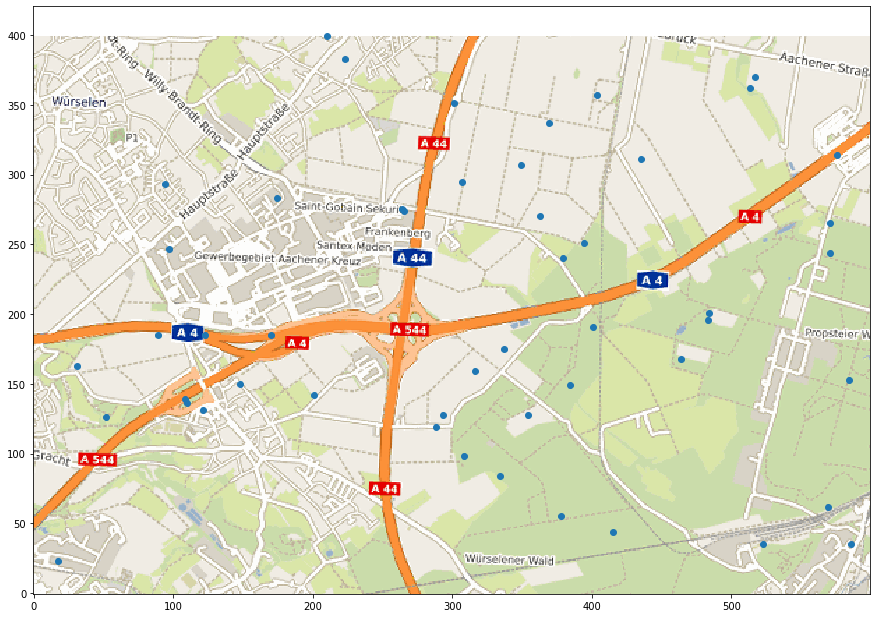

In [27]:
fig = plt.figure(figsize=(15,15))
print(img.shape)
plt.imshow(img2[1000:1400,1200:1800], origin="lower", )
plt.scatter(np.random.randint(0,600,50), np.random.randint(0,400,50))
plt.show()

## Plotting different WMS Layers

In [28]:
list(wms.contents)

['OSM-WMS',
 'OSM-Overlay-WMS',
 'TOPO-WMS',
 'TOPO-OSM-WMS',
 'SRTM30-Hillshade',
 'SRTM30-Colored',
 'SRTM30-Colored-Hillshade',
 'SRTM30-Contour']

### Plotting Topography

In [29]:
minx = 32286000
maxx = 32328000
miny = 5620000
maxy = 5648000

img3 = request_image_as_array(wms, layers = ['TOPO-OSM-WMS'], srs = 'EPSG:4647', extent = (minx,miny,maxx,maxy), size = (int((maxx-minx)/10),int((maxy-miny)/10)))

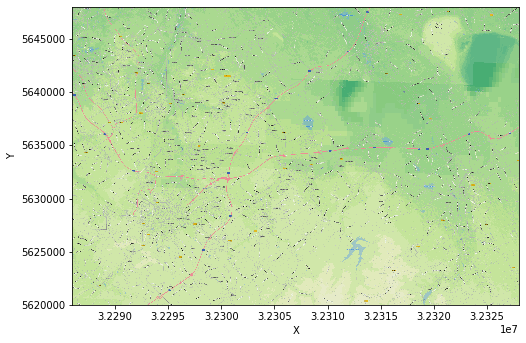

In [30]:
plot_wms(img3, extent = extent)

(2800, 4200, 4)


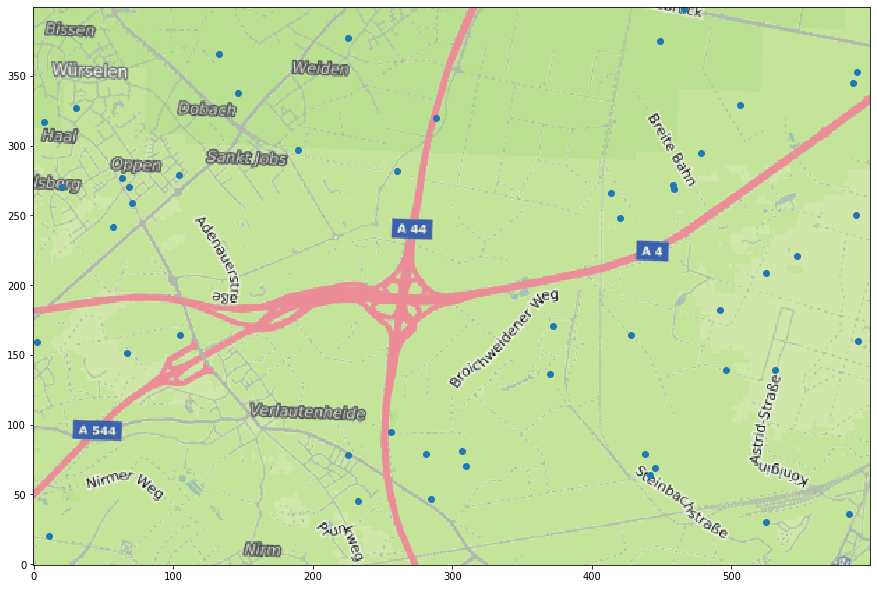

In [31]:
fig = plt.figure(figsize=(15,15))
print(img3.shape)
plt.imshow(img3[1000:1400,1200:1800], origin="lower")
plt.scatter(np.random.randint(0,600,50), np.random.randint(0,400,50))
plt.show()

### Plotting Hillshades

In [32]:
minx = 32286000
maxx = 32328000
miny = 5620000
maxy = 5648000

img4 = request_image_as_array(wms, layers = ['SRTM30-Colored-Hillshade'], srs = 'EPSG:4647', extent = (minx,miny,maxx,maxy), size = (int((maxx-minx)/10),int((maxy-miny)/10)))

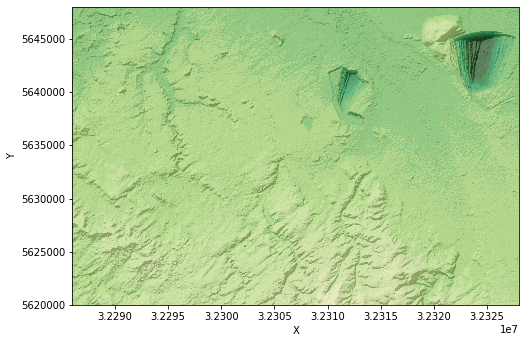

In [33]:
plot_wms(img4, extent = extent)

(2800, 4200, 4)


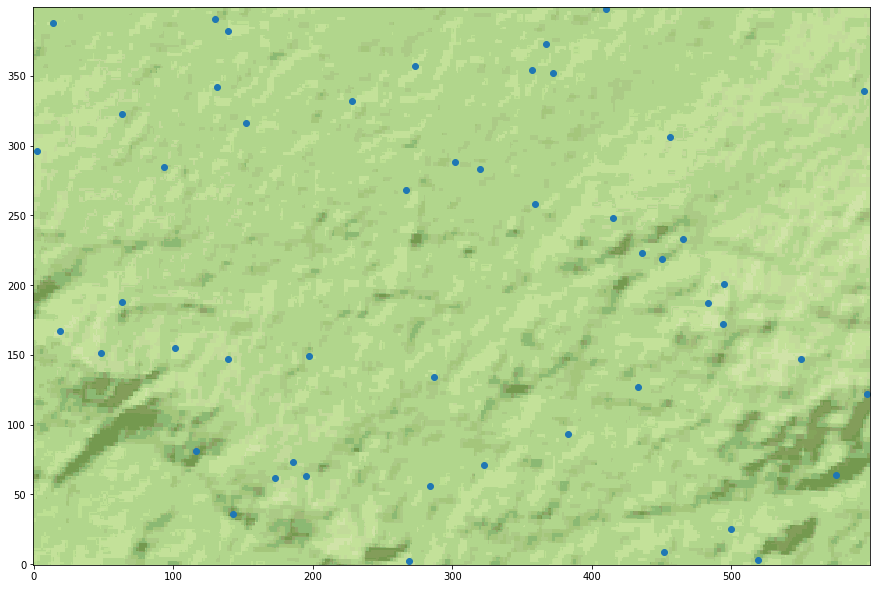

In [34]:
fig = plt.figure(figsize=(15,15))
print(img4.shape)
plt.imshow(img4[1000:1400,1200:1800], origin="lower")
plt.scatter(np.random.randint(0,600,50), np.random.randint(0,400,50))
plt.show()

# Loading WebMapService - NRW

In [35]:
wms2 = load_wms(path = 'https://www.wms.nrw.de/geobasis/wms_nw_hoehenschichten')

In [36]:
list(wms2.contents)

['WMS_NW_HOEHENSCHICHTEN',
 'nw_hoehenschichten_info',
 'nw_hoehenschichten_inspire',
 'nw_hoehenschichten_rgb',
 'nw_hoehenschichten_pan']

In [37]:
wms2['WMS_NW_HOEHENSCHICHTEN'].styles

{}

In [38]:
wms2['WMS_NW_HOEHENSCHICHTEN'].crsOptions

['EPSG:3034',
 'EPSG:31467',
 'EPSG:25831',
 'EPSG:25833',
 'EPSG:3857',
 'EPSG:4647',
 'EPSG:5649',
 'EPSG:4258',
 'EPSG:5650',
 'EPSG:3035',
 'EPSG:25832',
 'EPSG:31466',
 'EPSG:3043',
 'EPSG:5651',
 'EPSG:4326',
 'EPSG:5653',
 'EPSG:3044',
 'EPSG:3045',
 'EPSG:5652']

In [39]:
#No style available
wms2['WMS_NW_HOEHENSCHICHTEN'].styles

{}

In [40]:
wms2.getOperationByName('GetMap').formatOptions

['image/png', 'image/jpeg', 'image/tiff', 'image/png; mode=8bit']

In [41]:
minx = 32286000
maxx = 32328000
miny = 5620000
maxy = 5648000

img5 = request_image_as_array(wms2, layers = ['nw_hoehenschichten_rgb'], srs = 'EPSG:4647', extent = (minx,miny,maxx,maxy), form = 'image/tiff', size = (int((maxx-minx)/10),int((maxy-miny)/10)))

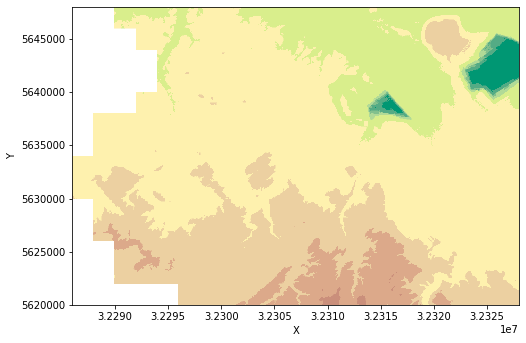

In [42]:
plot_wms(img5, extent = extent)

# Loading WebCoverageService

In [68]:
wcs = WebCoverageService('https://www.wcs.nrw.de/geobasis/wcs_nw_dgm')


In [69]:
wcs

## Get WebMapService Properties
Properties of the ```owslib.coverage.wcs201.WebCoverageService_2_0_1``` object can easily be retrieved in the following way.

## Service Metadata

In [70]:
wcs.identification.type

'OGC WCS'

In [71]:
wcs.identification.version

'2.0.1'

In [72]:
wcs.identification.title

'WCS NW DGM'

In [73]:
wcs.identification.abstract

'Höhenmodell des Landes NRW.'

## Available Layers

In [74]:
list(wcs.contents)

['nw_dgm']

## Details of a Layer

In [75]:
wcs.contents['nw_dgm'].boundingboxes

[{'nativeSrs': 'http://www.opengis.net/def/crs/EPSG/0/25832',
  'bbox': (278000.0, 5560000.0, 536000.0, 5828000.0)}]

In [76]:
wcs.contents['nw_dgm'].grid.axislabels

['x', 'y']

In [77]:
wcs.contents['nw_dgm'].grid.dimension

2

In [78]:
wcs.contents['nw_dgm'].grid.lowlimits

['0', '0']

In [79]:
wcs.contents['nw_dgm'].grid.highlimits

['257999', '267999']

In [80]:
wcs.contents['nw_dgm'].grid.offsetvectors

[['1.000000', '0'], ['0', '-1.000000']]

In [81]:
wcs.contents['nw_dgm'].timepositions

In [82]:
wcs.contents['nw_dgm'].grid

In [83]:
for layer in list(wcs.contents):
    print ("Layer Name:", layer)
    print ("Title:", wcs[layer].title, '\n')

Layer Name: nw_dgm
Title: None 



In [84]:
layer = 'nw_dgm'

In [85]:
print(wcs[layer].abstract)

None


In [86]:
print(wcs[layer].styles)

None


In [87]:
print ("CRS Options: ")
crs = sorted(wcs[layer].supportedCRS)
print ('\t', crs, '\n')

CRS Options: 
	 [] 



In [88]:
print ("Bounding Box: ")
bbox = wcs[layer].boundingBoxWGS84
print ('\t', bbox, '\n')

Bounding Box: 
	 None 



## Downloading WCS Data

In [94]:
subset_bbox = (372000,5614000374000,5616000)

In [ ]:
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[6]],
                         format='GeoTIFF',
                         crs='EPSG:4326', width=256, height=256)

https://www.wcs.nrw.de/geobasis/wcs_nw_dgm?REQUEST=GetCoverage&SERVICE=WCS&VERSION=2.0.1&COVERAGEID=nw_dgm&FORMAT=image/tiff&SUBSET=x(372000,374000)&SUBSET=y(5614000,5616000)&OUTFILE=dgm1_32_372_5614_2_nw